# Demonstration

`nanodrr` features the same capabilities as `DiffDRR`, but with improved performance and interfaces.

This tutorial highlights the important similarities and differences between `nanodrr` and `DiffDRR`:

- A new `Subject` class
- A functional DRR rendering interface
- A new internal camera geometry based on pinhole cameras
- The ability to freely exchange subjects, intrinsics, and extrinsics at runtime

Another fun change is that, with `pytorch>=2.10`, rendering without a labelmap works on MPS!

In [1]:
import matplotlib.pyplot as plt
import torch

from nanodrr.camera import make_k_inv, make_rt_inv
from nanodrr.data import Subject, download_deepfluoro
from nanodrr.plot import plot_drr

device = "cuda" if torch.cuda.is_available() else "cpu"

## Subject

`nanodrr` also uses a `Subject` to hold a volume, (optional) labelmap, and coordinate frame transforms. However, now volumes are **not** centered at the origin by default.

In [ ]:
# Load the volume and (optional) segmentation
imagepath, labelpath = download_deepfluoro(subject=1)
subject = Subject.from_filepath(imagepath, labelpath).to(device)

Additionally, all coordinate transforms needed for rendering (camera → world → voxel → grid sample) are fused, which dramatically speeds up rendering.

## Functional interface

`nanodrr` provides a functional interface for DRR rendering (`nanodrr.drr.render`). 

The inputs are:

- A `Subject` object
- An (batched) inverse intrinsic matrix
- An (batched) inverse extrinsic matrix

Intrinsic and extrinsic matrices come from the [pinhole camera model](https://ksimek.github.io/2012/08/13/introduction/).
Utilities are provided to construct these matrices from standard C-arm imaging parameters.

In [3]:
from nanodrr.drr import render

In [4]:
# Construct the inverse intrinsic matrix from C-arm imaging parameters
sdd = 1020.0
delx = dely = 2.0
x0 = y0 = 0.0
height = width = 200

k_inv = make_k_inv(sdd, delx, dely, x0, y0, height, width, device=device)
sdd = torch.tensor([sdd], device=device)

Although subject's are no longer centered at the origin in world coordinates, we can achieve the same camera parameterization as `DiffDRR` by constructing the C-arm pose relative to the subject's isocenter.

In [ ]:
# Construct the inverse extrinsic matrix
rt_inv = make_rt_inv(
    torch.tensor(
        [
            [0.0, 0.0, 0.0],
            [30.0, 0.0, 0.0],
        ],
        device=device,
    ),
    torch.tensor(
        [
            [0.0, 850.0, 0.0],
            [0.0, 850.0, 0.0],
        ],
        device=device,
    ),
    orientation="AP",
    isocenter=subject.isocenter,  # Move to the subject's isocenter
)

In `DiffDRR`, we were constrined to rendering X-rays from a single subject with fixed intrinsics. With the functional interface in `nanodrr`, we can freely exchange the subject and intrinsics, as well as the C-arm pose.

Also, note that the intrinsic matrix can be different for every image being rendered, which is useful for biplane C-arm setups.

In [6]:
# Render the DRR
img = render(subject, k_inv, rt_inv, sdd, height, width)
print(img.shape)

torch.Size([2, 8, 200, 200])


As in `DiffDRR`, if our `Subject` has a labelmap, the rendered DRRs are multichannel with each channel corresponding to a distinct anatomical structure.

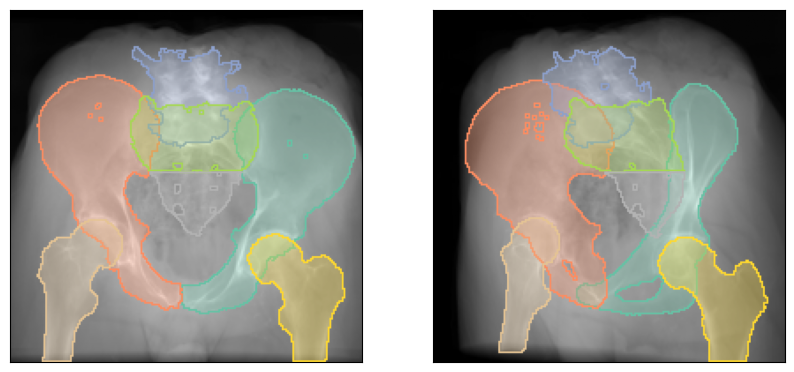

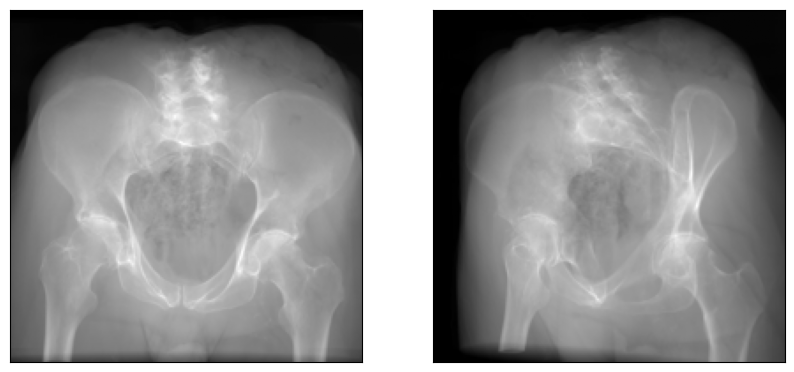

In [7]:
# Plot the DRR and overlay the projected segmentation labels
plot_drr(img, ticks=False)
plt.show()

# Plot the DRR
plot_drr(img.sum(dim=1, keepdim=True), ticks=False)
plt.show()

## Class interface

The traditional class interface from `DiffDRR` is also available if you wish to have fixed intrinsics. 
However, note that the new class interface also let's you freely change the user at runtime.

In [8]:
from nanodrr.drr import DRR

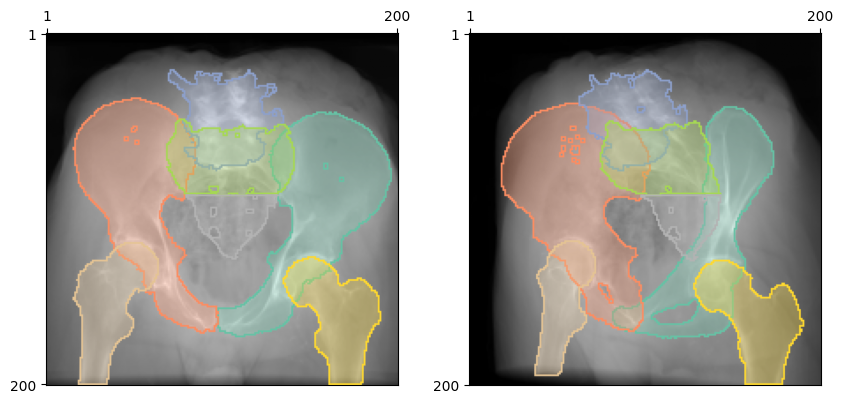

In [9]:
# Initialize the DRR module from the intrinsics
drr = DRR.from_carm_intrinsics(
    sdd,
    delx,
    dely,
    x0,
    y0,
    height,
    width,
    device=device,
)

# Render with fixed intrinsics
img = drr(subject, rt_inv)
plot_drr(img)
plt.show()